# Weight tracking, analysis and forecast

## Setup

In [1]:
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import os
import sys
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
print(f'Python = {sys.version}')
print(f'Numpy = {np.__version__}')
print(f'Tensorflow = {tf.__version__}')

Python = 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
Numpy = 1.20.3
Tensorflow = 2.5.0


In [3]:
import weightlib as wl

# Data Extraction

=> file "data_BEN.zip" contains the file "weight.csv" with all daily measurements of total mass, fat mass.

=> file "Suivi_Poids.csv" has manually-entered daily numbers for total mass and fat mass, plus nutrition data (lipid, carbs, proteines), and calories data (ingested, spent with cardio, spent with strength training)

In [4]:
ROOT = os.getcwd() + '/'
print(f'current working directory is {ROOT}')
print(f'contains :')
print(f'{os.listdir(ROOT)}')

current working directory is c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/
contains :
['.git', '.ipynb_checkpoints', 'data_BEN.zip', 'desktop.ini', 'figure.jpg', 'model.png', 'pat.txt', 'polar-user-data-export.zip', 'README.md', 'Suivi_Poids.csv', 'test_methodes.xlsx', 'tmp', 'weight.ipynb', 'weightlib.py', 'weight_arima.ipynb', 'weight_rapport.ipynb', 'weight_recherche.ipynb', '__pycache__']


In [5]:
ds = wl.GetData(ROOT + 'data_BEN.zip', ROOT + 'Suivi_Poids.csv')

In [6]:
ds.extract()

Extraction fichier Zip Healthmate dans c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/tmp...
... Done


In [7]:
raw_df = ds.get_dataframe()

raw_df.set_index('date', inplace=True)

In [8]:
raw_df

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength
date,,,,,,,,,
2020-09-01,101.250000,33.020000,2015.0,262.0,48.0,120.0,281.0,281.0,0.0
2020-09-02,101.150000,31.945000,1942.0,162.0,94.0,100.0,419.0,419.0,0.0
2020-09-03,101.200000,30.930000,1938.0,227.0,72.0,93.0,403.0,403.0,0.0
2020-09-04,100.800000,29.460000,1851.0,274.0,43.0,91.0,439.0,439.0,0.0
2020-09-05,100.600000,31.450000,1774.0,214.0,54.0,90.0,563.0,563.0,0.0
...,...,...,...,...,...,...,...,...,...
2021-12-20,68.640000,8.725000,1832.0,181.0,44.0,179.0,446.0,0.0,446.0
2021-12-21,67.980000,8.641000,1791.0,185.0,36.0,176.0,406.0,0.0,406.0
2021-12-22,68.050000,8.785455,2034.0,245.0,62.0,104.0,455.0,0.0,455.0


### Dataframe with 'engineered' features

In [9]:
df = raw_df

# créée masse_seche
df['masse_seche'] = df['masse_totale'] - df['masse_grasse']

# calories nettes
df['calories_nettes'] = df['calories_in'] - df['calories_exercice']

# body fat percentage
df['bf_perc'] = df['masse_grasse'] / df['masse_totale']


In [10]:
df['msj'] = df['masse_totale'].apply(wl.msj)
df['oxf'] = df['masse_totale'].apply(wl.oxf)
df['sch'] = df['masse_totale'].apply(wl.sch)
df['kma'] = df['masse_seche'].apply(wl.kma)

# df['base_metabolism'] = df[['msj','oxf','sch','kma']].apply(np.mean, axis=1)
df['base_metabolism'] = df['kma']  # on utilise Katch Mac Ardle pour métabolisme de base

df['rest_metabolism'] = df['base_metabolism'] * 1.10  # coefficient adapté de façon à ce que le déficit calorique soit au voisinage de zéro quand les courbes s'inversent entre sèche et bulk

df['calories_deficit'] = df['calories_in'] - df['rest_metabolism'] - df['calories_exercice']

In [11]:
df

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,calories_nettes,bf_perc,msj,oxf,sch,kma,base_metabolism,rest_metabolism,calories_deficit
date,,,,,,,,,,,,,,,,,,,
2020-09-01,101.250000,33.020000,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,68.230000,1734.0,0.326123,1886.97750,2030.750000,2034.64000,1843.768000,1843.768000,2028.14480,-294.14480
2020-09-02,101.150000,31.945000,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,69.205000,1523.0,0.315818,1885.97850,2029.330000,2033.49280,1864.828000,1864.828000,2051.31080,-528.31080
2020-09-03,101.200000,30.930000,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,70.270000,1535.0,0.305632,1886.47800,2030.040000,2034.06640,1887.832000,1887.832000,2076.61520,-541.61520
2020-09-04,100.800000,29.460000,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,71.340000,1412.0,0.292262,1882.48200,2024.360000,2029.47760,1910.944000,1910.944000,2102.03840,-690.03840
2020-09-05,100.600000,31.450000,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,69.150000,1211.0,0.312624,1880.48400,2021.520000,2027.18320,1863.640000,1863.640000,2050.00400,-839.00400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-20,68.640000,8.725000,1832.0,181.0,44.0,179.0,446.0,0.0,446.0,59.915000,1386.0,0.127112,1561.20360,1567.688000,1660.53808,1664.164000,1664.164000,1830.58040,-444.58040
2021-12-21,67.980000,8.641000,1791.0,185.0,36.0,176.0,406.0,0.0,406.0,59.339000,1385.0,0.127111,1554.61020,1558.316000,1652.96656,1651.722400,1651.722400,1816.89464,-431.89464
2021-12-22,68.050000,8.785455,2034.0,245.0,62.0,104.0,455.0,0.0,455.0,59.264545,1579.0,0.129103,1555.30950,1559.310000,1653.76960,1650.114182,1650.114182,1815.12560,-236.12560


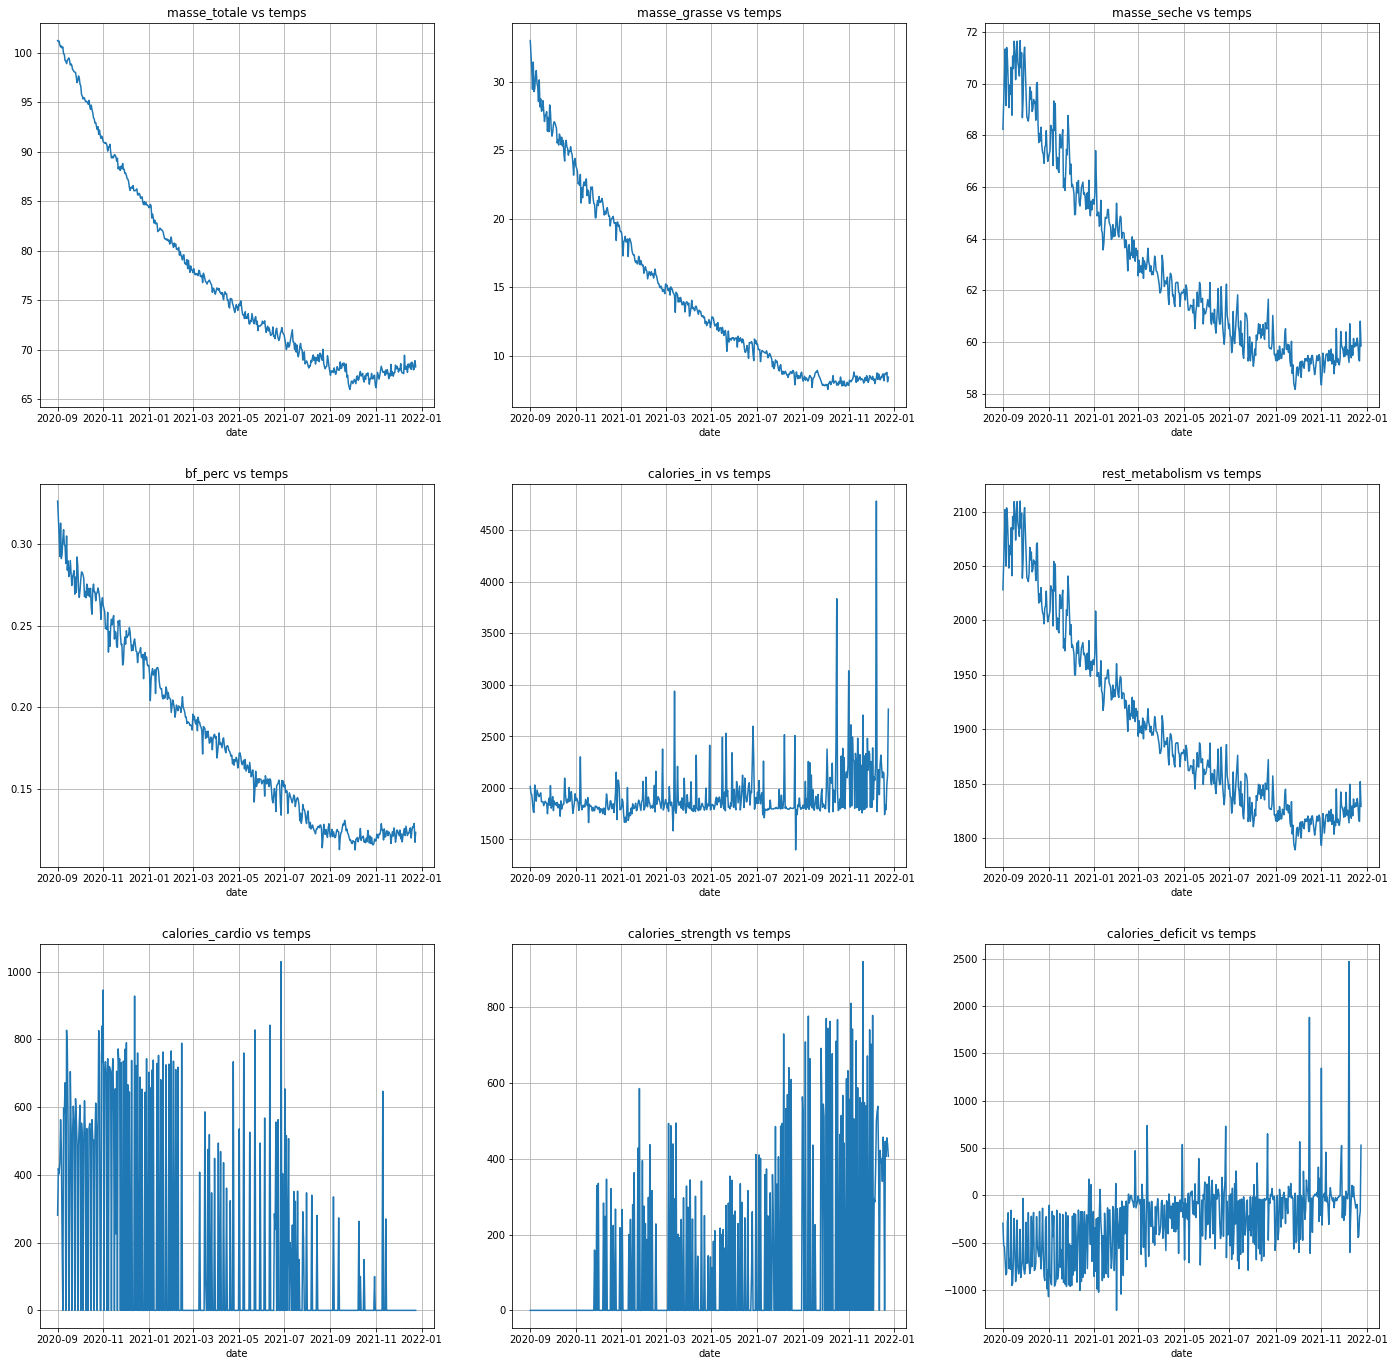

In [12]:
wl.plot_columns(df)

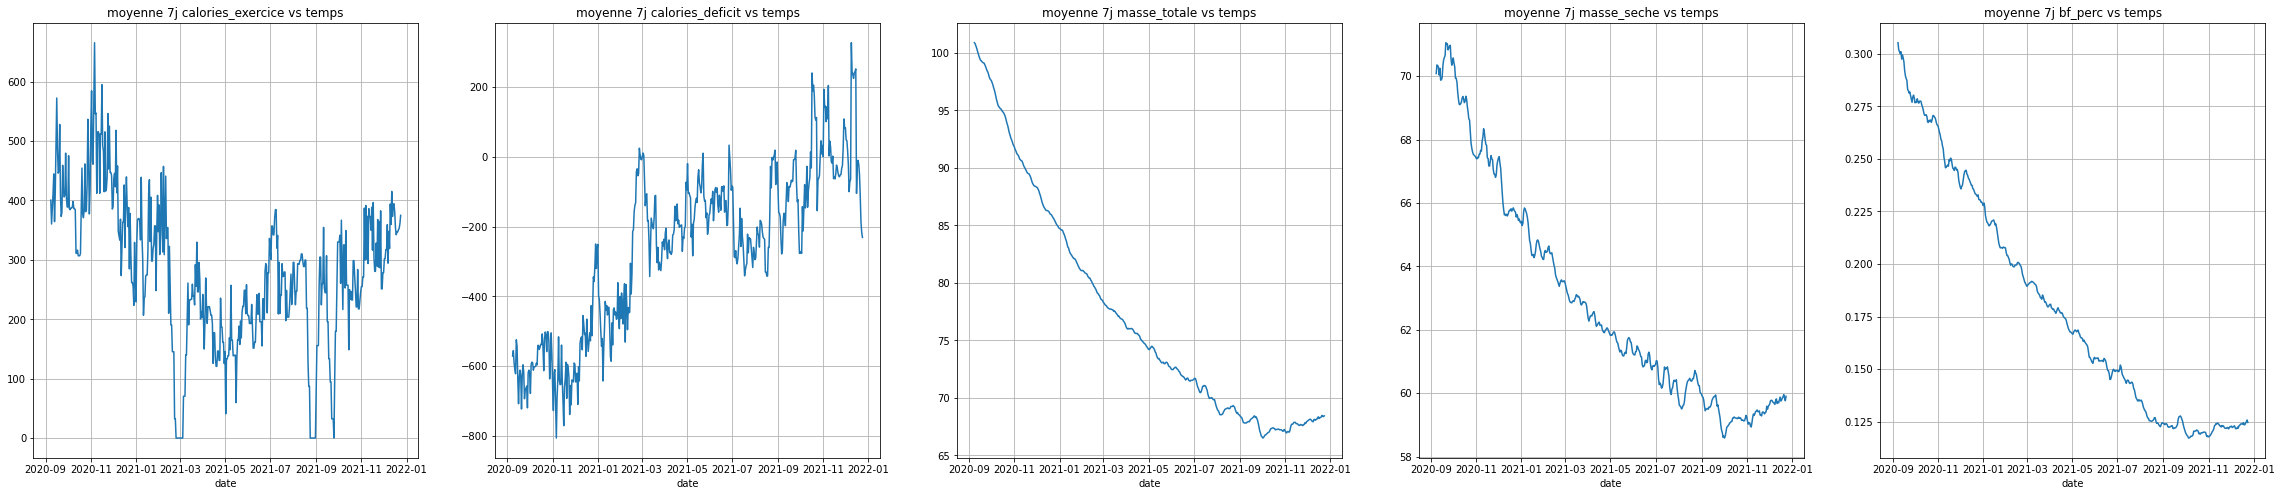

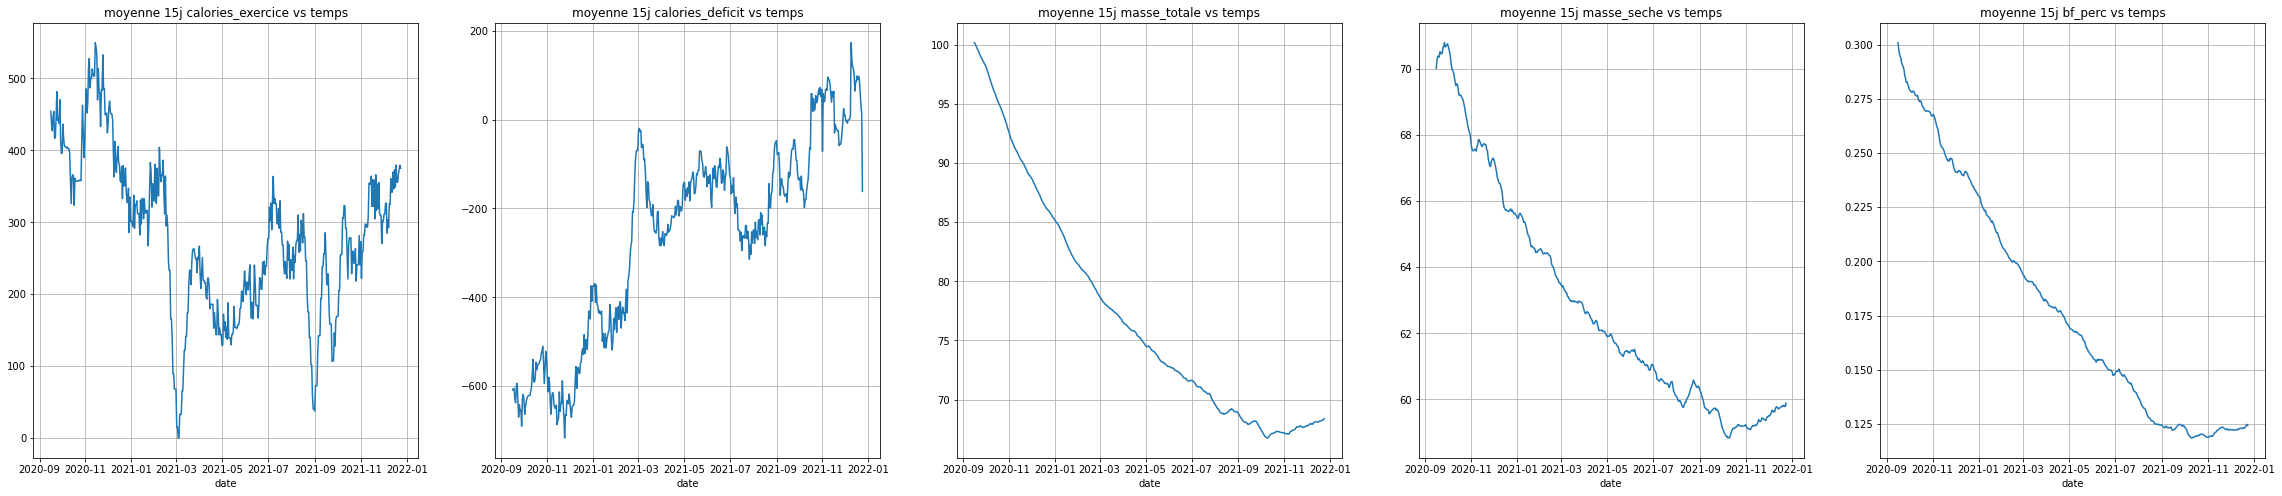

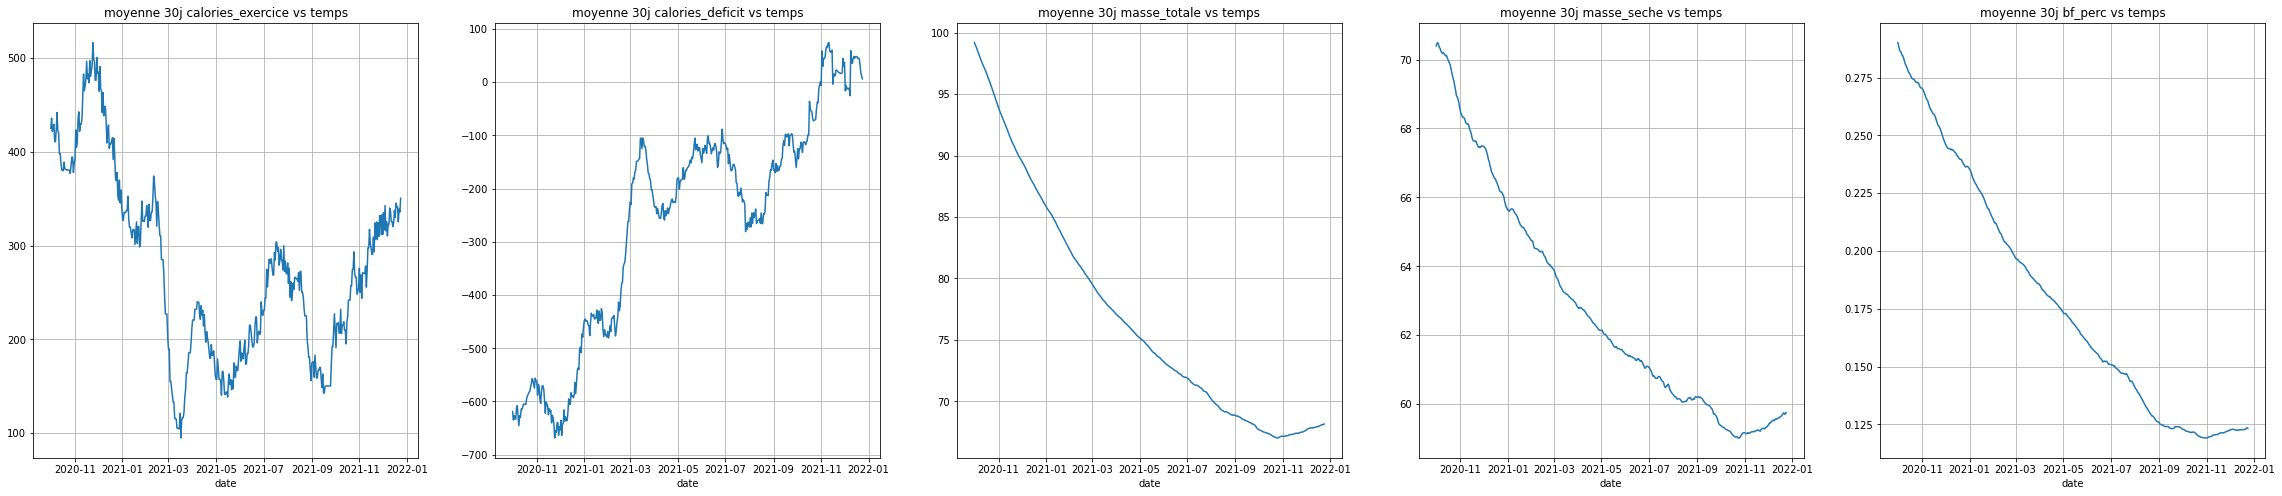

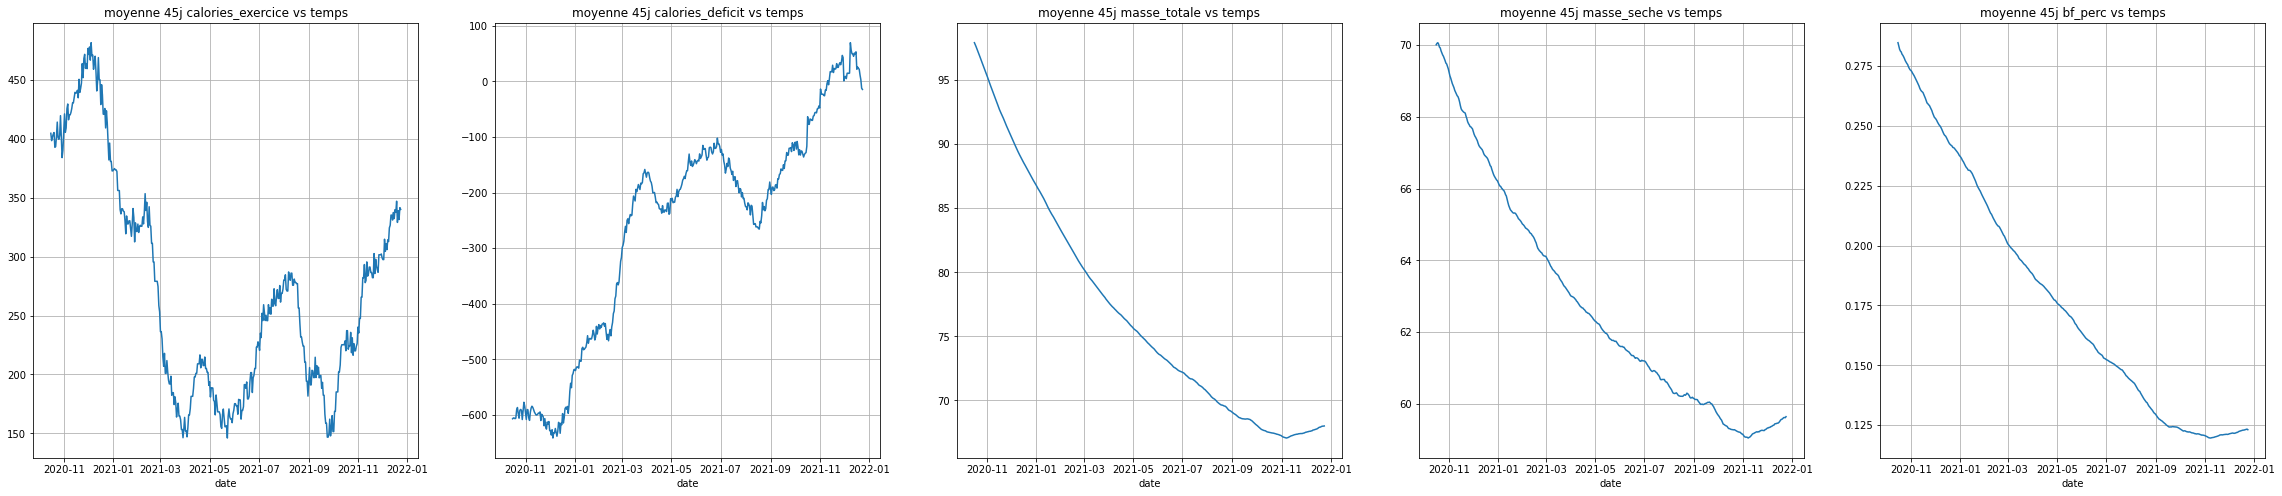

In [13]:
window_list = [7,15,30,45]

for w in window_list:
    wl.plot_moyennes(df, window=w)

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


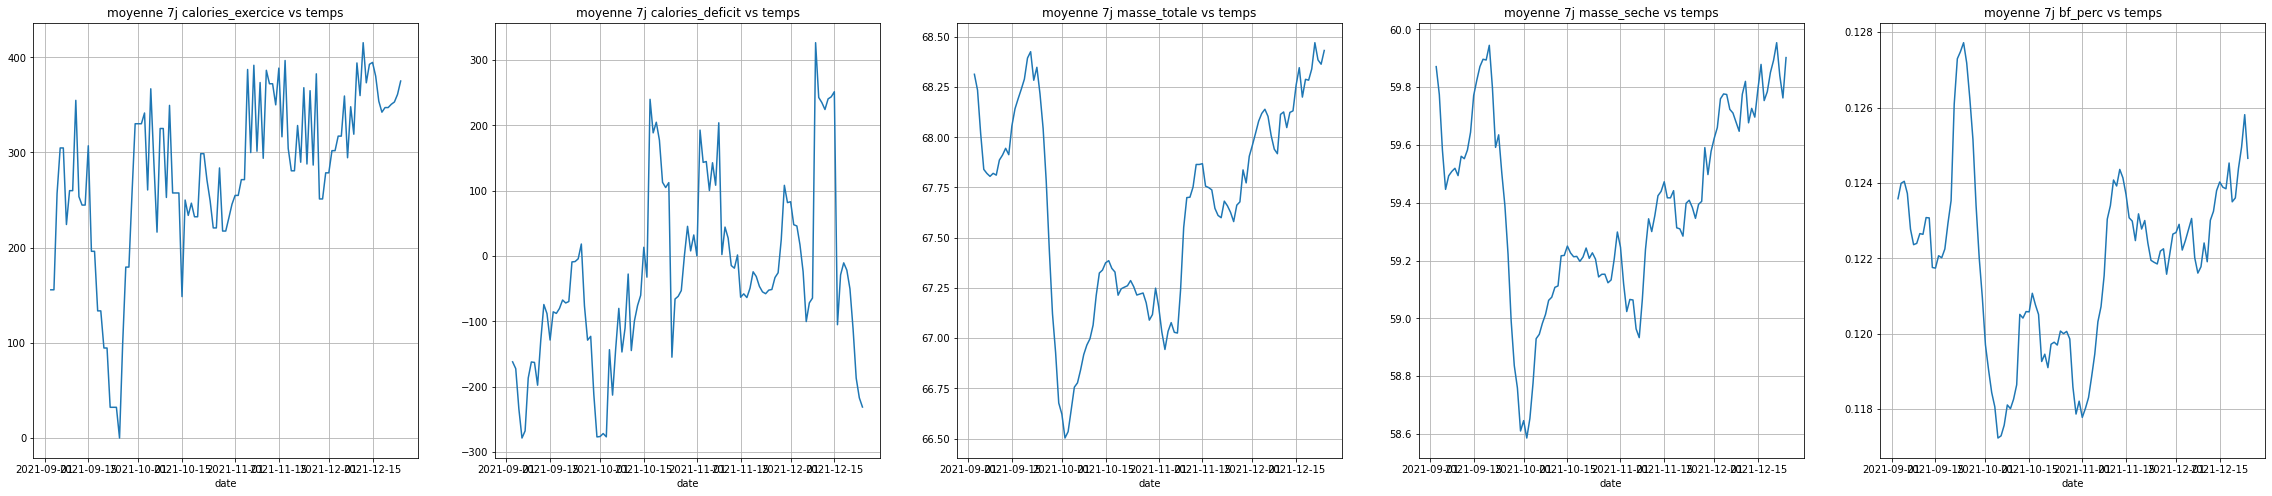

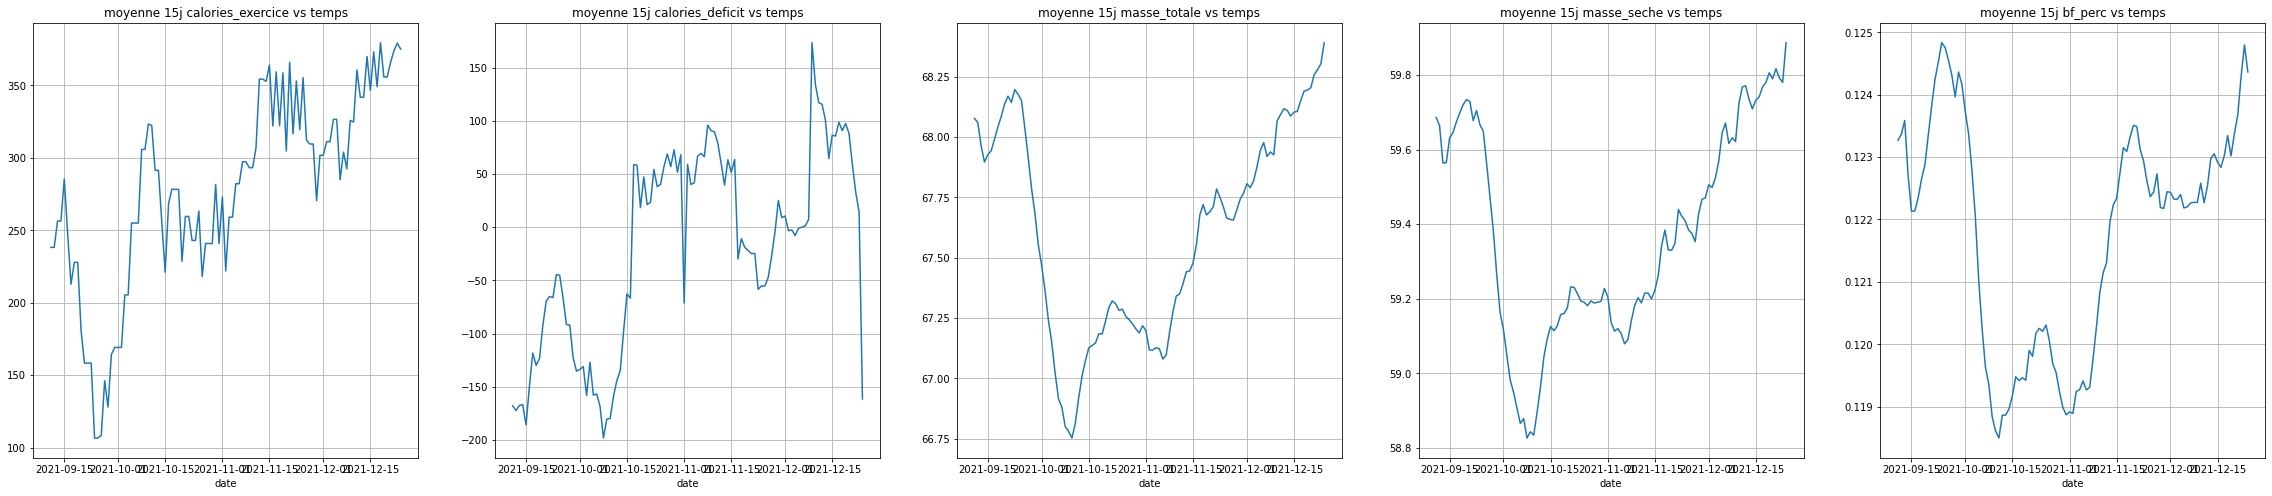

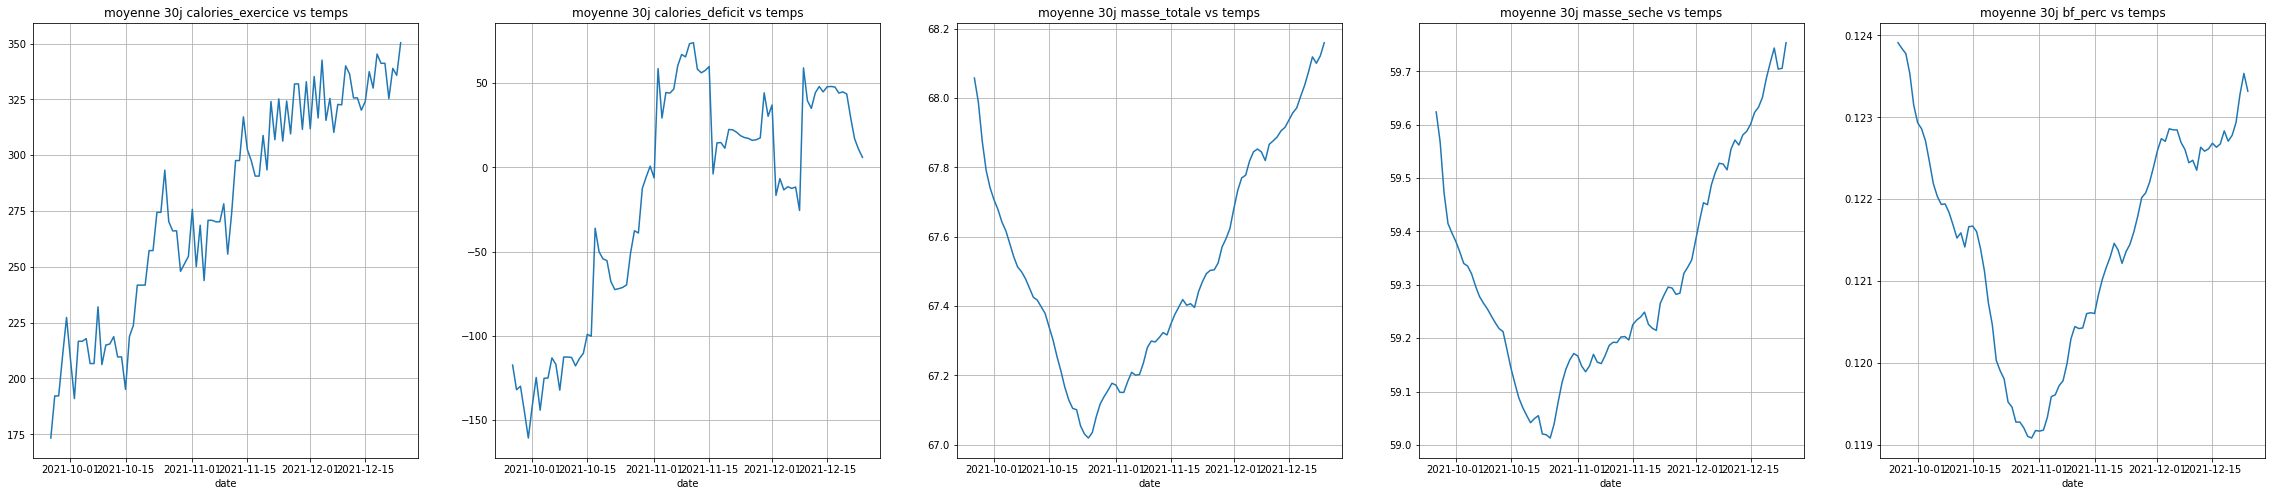

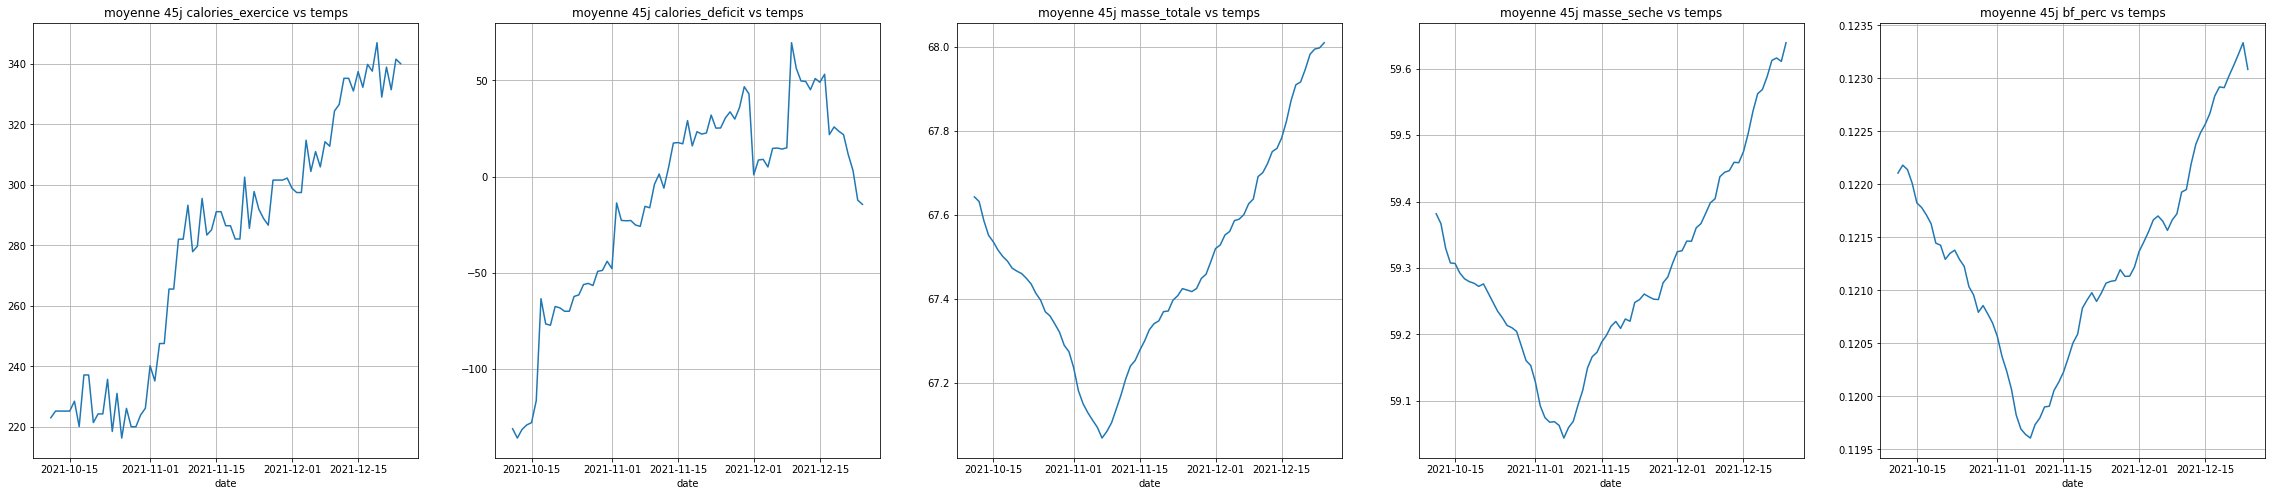

In [14]:
over_last_days = 120

start_date = datetime.date.today() - datetime.timedelta(days = over_last_days)
index_to_drop = [df.index < start_date]

df_last = df.drop(index = df.index[index_to_drop])

window_list = [7,15, 30, 45]

for w in window_list:
    wl.plot_moyennes(df=df_last, window=w)

# On distingue deux périodes :
- une période de "sèche" jusqu'à fin septembre 2021 environ
- une période de "bulk" plus ou moins clean (?) à partir d'octobre 2021

In [15]:
cut_off = datetime.date(2021,10,1)

df_seche = df[df.index < cut_off]

df_bulk = df[df.index >= cut_off]


In [16]:
df_seche

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,...,sch,kma,base_metabolism,rest_metabolism,calories_deficit,moyenne calories_exercice,moyenne calories_deficit,moyenne masse_totale,moyenne masse_seche,moyenne bf_perc
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,101.250000,33.020000,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,68.230000,...,2034.640000,1843.768000,1843.768000,2028.144800,-294.144800,NaN,NaN,NaN,NaN,NaN
2020-09-02,101.150000,31.945000,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,69.205000,...,2033.492800,1864.828000,1864.828000,2051.310800,-528.310800,NaN,NaN,NaN,NaN,NaN
2020-09-03,101.200000,30.930000,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,70.270000,...,2034.066400,1887.832000,1887.832000,2076.615200,-541.615200,NaN,NaN,NaN,NaN,NaN
2020-09-04,100.800000,29.460000,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,71.340000,...,2029.477600,1910.944000,1910.944000,2102.038400,-690.038400,NaN,NaN,NaN,NaN,NaN
2020-09-05,100.600000,31.450000,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,69.150000,...,2027.183200,1863.640000,1863.640000,2050.004000,-839.004000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,66.250000,7.985000,1990.0,167.0,63.0,168.0,566.0,0.0,566.0,58.265000,...,1633.120000,1628.524000,1628.524000,1791.376400,-367.376400,149.511111,-119.039613,68.366786,59.874469,0.124211
2021-09-27,66.000000,7.835714,1812.0,121.0,53.0,172.0,0.0,0.0,0.0,58.164286,...,1630.252000,1626.348571,1626.348571,1788.983429,23.016571,162.088889,-126.244333,68.315304,59.832580,0.124161
2021-09-28,66.433333,7.908333,1845.0,168.0,55.0,167.0,544.0,0.0,544.0,58.525000,...,1635.223200,1634.140000,1634.140000,1797.554000,-496.554000,147.866667,-110.343353,68.244415,59.780631,0.124009


In [17]:
df_seche.describe()

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,...,sch,kma,base_metabolism,rest_metabolism,calories_deficit,moyenne calories_exercice,moyenne calories_deficit,moyenne masse_totale,moyenne masse_seche,moyenne bf_perc
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,79.572731,15.884847,1872.154430,177.946835,58.810127,129.792405,277.632911,195.232911,82.400000,63.687885,...,1785.958375,1745.658311,1745.658311,1920.224142,-325.702623,274.708127,-320.637729,79.121752,63.560639,0.191683
std,9.694319,6.348998,145.471486,41.029638,14.950405,29.082369,295.954182,292.398130,164.693815,3.417248,...,111.213231,73.812555,73.812555,81.193811,343.479708,100.223849,181.448012,8.403577,2.939529,0.046509
min,66.000000,7.685000,1399.000000,43.000000,8.000000,13.000000,0.000000,0.000000,0.000000,58.164286,...,1630.252000,1626.348571,1626.348571,1788.983429,-1215.191200,146.066667,-641.409529,68.129495,59.704488,0.123645
25%,71.583333,10.690000,1799.000000,154.000000,48.000000,114.000000,0.000000,0.000000,0.000000,60.908333,...,1694.304000,1685.620000,1685.620000,1854.182000,-595.616000,188.688889,-481.389680,72.013056,61.090648,0.151660
50%,77.050000,14.260000,1831.000000,173.000000,58.000000,133.000000,220.000000,0.000000,0.000000,62.776667,...,1757.017600,1725.976000,1725.976000,1898.573600,-245.343200,251.966667,-229.255792,77.100815,62.854152,0.184726
75%,86.416667,20.616667,1890.500000,199.500000,69.500000,147.000000,544.500000,489.500000,0.000000,65.988333,...,1864.472000,1795.348000,1795.348000,1974.882800,-49.478400,345.177778,-172.181139,85.592870,65.767481,0.231508
max,101.250000,33.020000,2940.000000,334.000000,106.000000,225.000000,1041.000000,1030.000000,776.000000,71.663333,...,2034.640000,1917.928000,1917.928000,2109.720800,738.397600,481.511111,-102.019840,97.909815,70.065500,0.284743


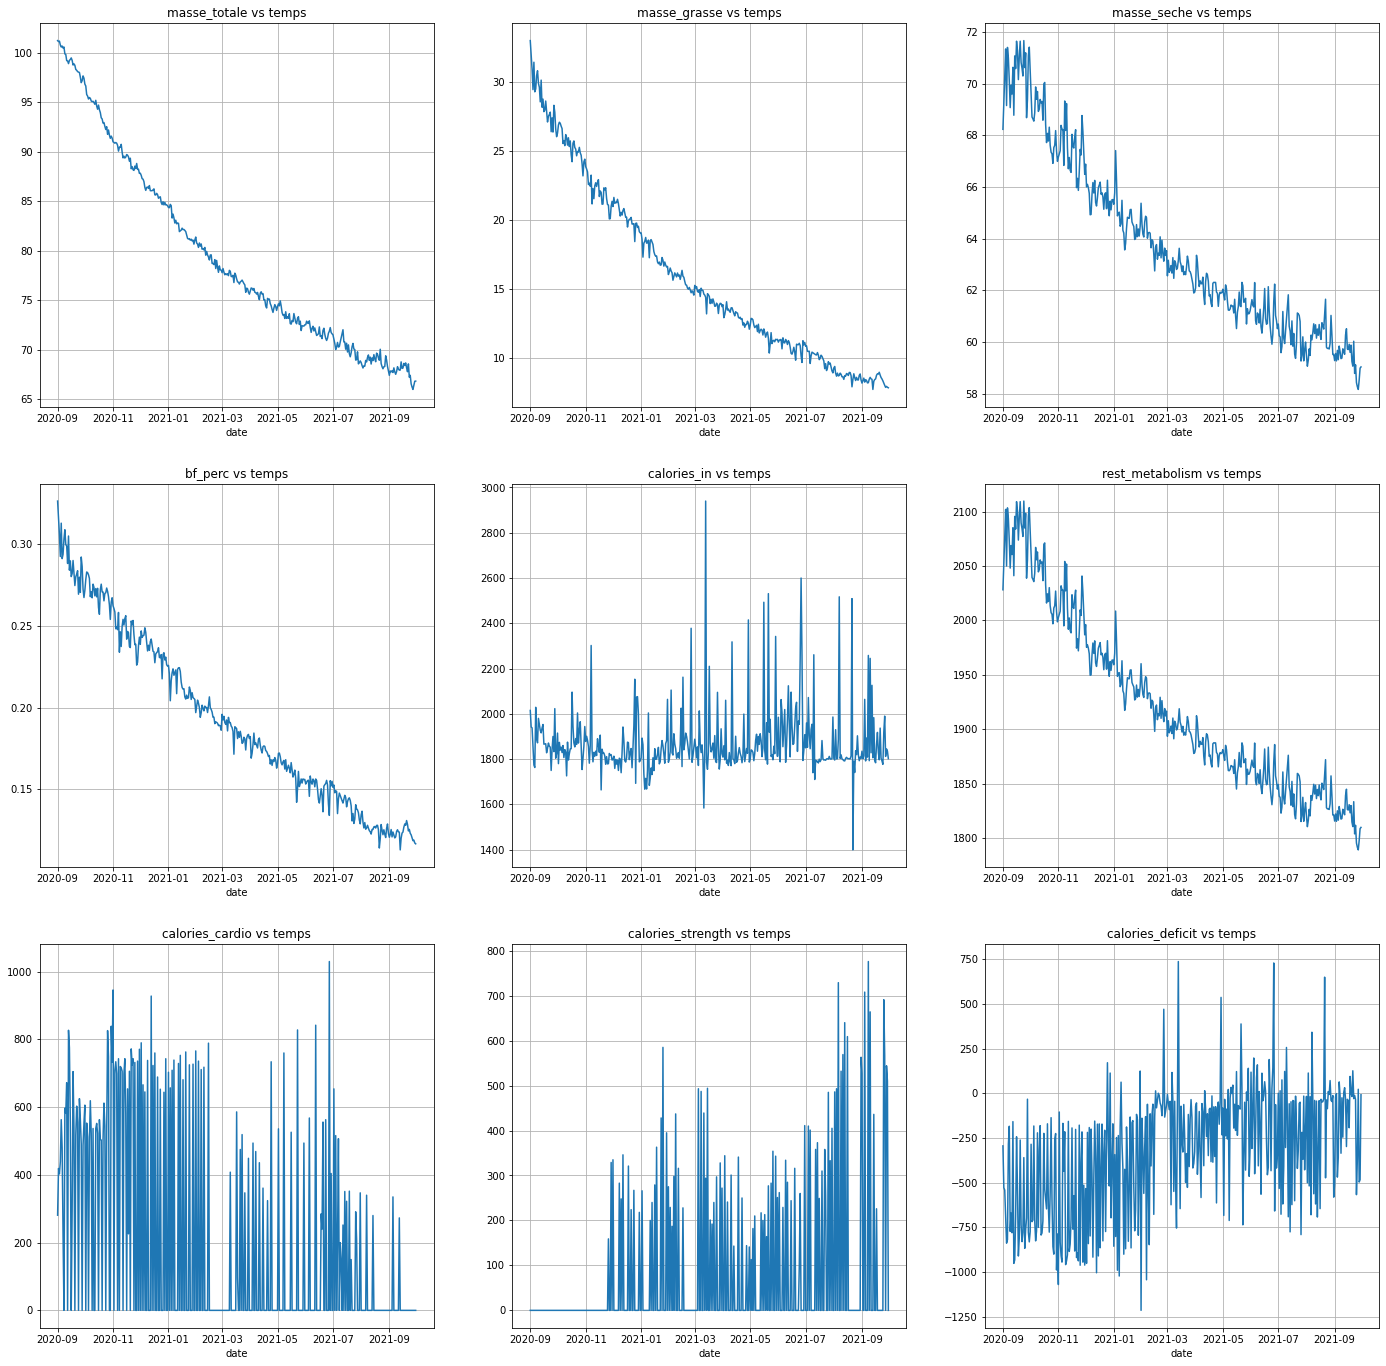

In [18]:
wl.plot_columns(df=df_seche)

In [19]:
df_bulk

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,...,sch,kma,base_metabolism,rest_metabolism,calories_deficit,moyenne calories_exercice,moyenne calories_deficit,moyenne masse_totale,moyenne masse_seche,moyenne bf_perc
date,,,,,,,,,,,,,,,,,,,,,
2021-10-01,66.591667,7.896667,1799.0,119.0,61.0,191.0,0.0,0.0,0.0,58.695000,...,1637.039600,1637.812000,1637.812000,1801.593200,-2.593200,151.533333,-110.028435,68.079587,59.676655,0.123410
2021-10-02,66.792857,7.887143,1974.0,183.0,31.0,124.0,770.0,0.0,770.0,58.905714,...,1639.347657,1642.363429,1642.363429,1806.599771,-602.599771,151.533333,-109.353261,68.030513,59.645433,0.123235
2021-10-03,67.018000,7.900000,2378.0,143.0,52.0,189.0,0.0,0.0,0.0,59.118000,...,1641.930496,1646.948800,1646.948800,1811.643680,566.356320,168.644444,-121.670127,67.966651,59.604523,0.123014
2021-10-04,66.783333,7.541667,2095.0,153.0,74.0,200.0,744.0,0.0,744.0,59.241667,...,1639.238400,1649.620000,1649.620000,1814.582000,-463.582000,168.644444,-108.044289,67.910384,59.570701,0.122787
2021-10-05,66.583333,7.953333,1799.0,174.0,48.0,152.0,0.0,0.0,0.0,58.630000,...,1636.944000,1636.408000,1636.408000,1800.048800,-1.048800,185.177778,-117.668778,67.857125,59.542738,0.122508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-20,68.640000,8.725000,1832.0,181.0,44.0,179.0,446.0,0.0,446.0,59.915000,...,1660.538080,1664.164000,1664.164000,1830.580400,-444.580400,329.000000,21.745655,67.947096,59.587959,0.123021
2021-12-21,67.980000,8.641000,1791.0,185.0,36.0,176.0,406.0,0.0,406.0,59.339000,...,1652.966560,1651.722400,1651.722400,1816.894640,-431.894640,338.911111,11.386417,67.982707,59.612431,0.123120
2021-12-22,68.050000,8.785455,2034.0,245.0,62.0,104.0,455.0,0.0,455.0,59.264545,...,1653.769600,1650.114182,1650.114182,1815.125600,-236.125600,331.444444,3.122048,67.995040,59.616075,0.123225


In [20]:
df_bulk.describe()

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,...,sch,kma,base_metabolism,rest_metabolism,calories_deficit,moyenne calories_exercice,moyenne calories_deficit,moyenne masse_totale,moyenne masse_seche,moyenne bf_perc
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,...,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,67.641448,8.226022,2143.905882,206.152941,57.400000,183.141176,312.882353,18.000000,294.882353,59.415426,...,1649.082687,1653.373196,1653.373196,1818.710516,12.313013,268.092810,-24.344822,67.522361,59.318577,0.121479
std,0.612376,0.271062,441.974671,68.882320,22.155404,31.329339,294.622778,82.781842,301.150943,0.457214,...,7.025183,9.875828,9.875828,10.863411,433.707897,50.704789,59.824621,0.261799,0.163049,0.001017
min,66.171429,7.541667,1741.000000,71.000000,22.000000,95.000000,0.000000,0.000000,0.000000,58.334286,...,1632.218629,1630.020571,1630.020571,1793.022629,-612.512400,151.533333,-136.018836,67.068398,59.043932,0.119606
25%,67.283333,8.030000,1813.000000,158.000000,44.000000,167.000000,0.000000,0.000000,0.000000,59.175000,...,1644.974400,1648.180000,1648.180000,1812.998000,-130.428000,225.222222,-67.596537,67.340710,59.210051,0.120831
50%,67.661111,8.212857,2100.000000,199.000000,55.000000,183.000000,375.000000,0.000000,340.000000,59.360000,...,1649.308267,1652.176000,1652.176000,1817.393600,-23.302400,282.111111,-6.032187,67.488292,59.283624,0.121425
75%,68.045455,8.441000,2293.000000,243.000000,62.000000,198.000000,548.000000,0.000000,547.000000,59.671250,...,1653.717455,1658.899000,1658.899000,1824.788900,10.744000,302.555556,22.672171,67.700684,59.435108,0.122213
max,69.455000,8.811250,4785.000000,511.000000,184.000000,264.000000,920.000000,647.000000,920.000000,60.805833,...,1669.887760,1683.406000,1683.406000,1851.746600,2471.170400,347.000000,69.621252,68.079587,59.676655,0.123410


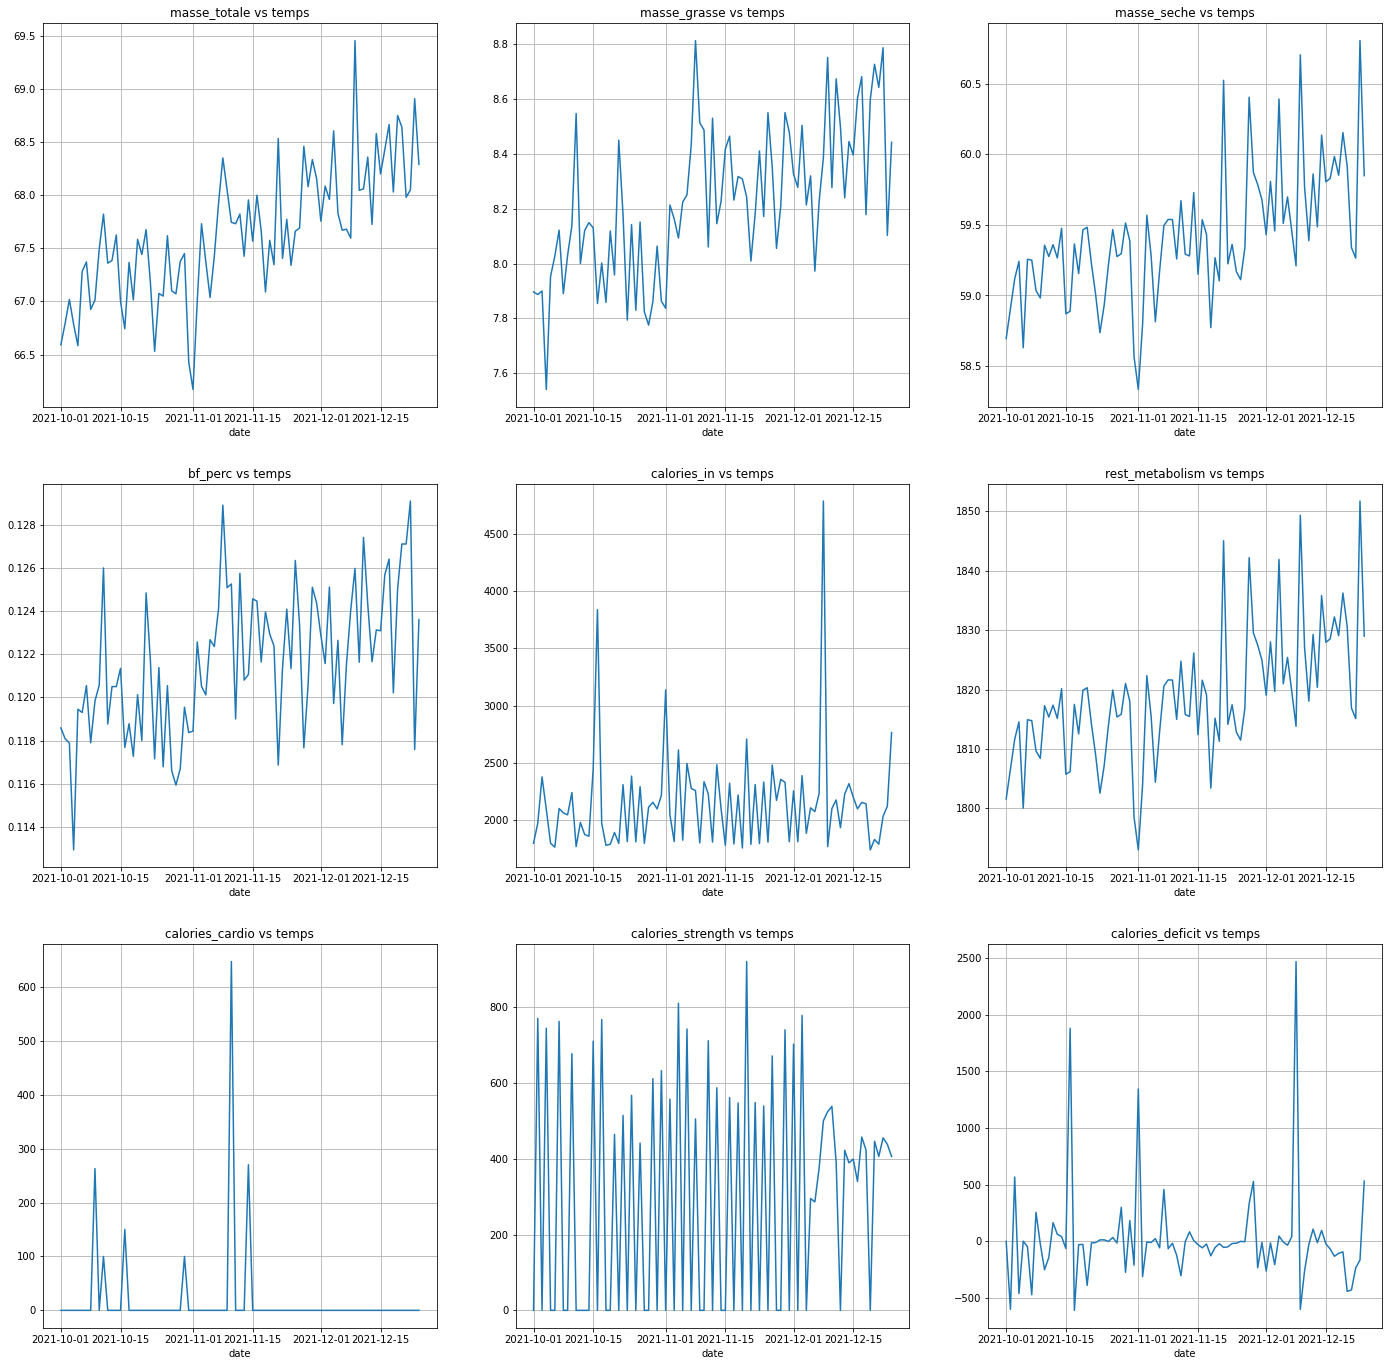

In [21]:
wl.plot_columns(df=df_bulk)

# Quelles dynamiques sur les deux périodes ?

rythme mensuel moyen sur la période de masse_totale = -2.476 avec coeff correlation = 95.0%
rythme mensuel moyen sur la période de masse_seche = -0.861 avec coeff correlation = 92.0%
rythme mensuel moyen sur la période de bf_perc = -0.014 avec coeff correlation = 97.0%


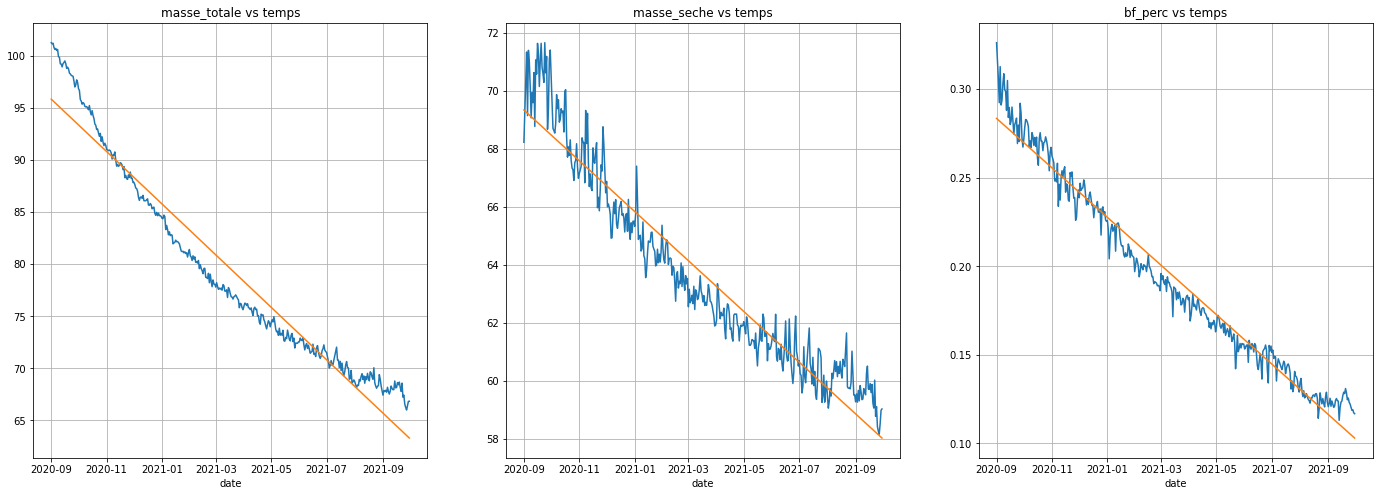

In [22]:
wl.plot_trends(df_seche)

rythme mensuel moyen sur la période de masse_totale = 0.552 avec coeff correlation = 55.0%
rythme mensuel moyen sur la période de masse_seche = 0.338 avec coeff correlation = 37.0%
rythme mensuel moyen sur la période de bf_perc = 0.002 avec coeff correlation = 29.0%


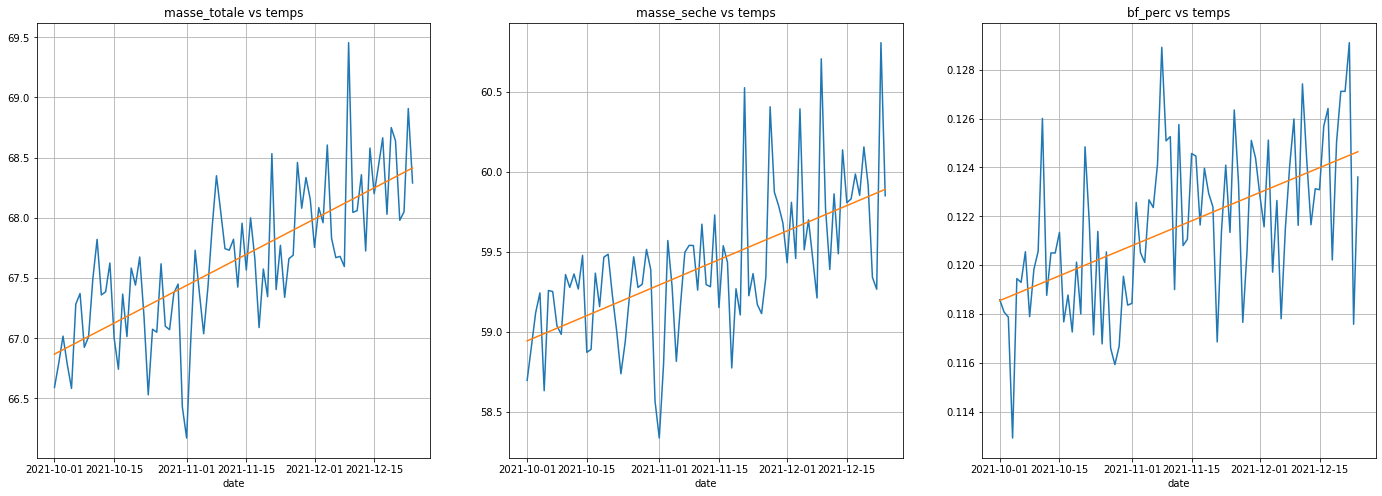

In [23]:
wl.plot_trends(df_bulk)

# Quelle(s) différence(s) principale(s) entre ces deux périodes ??

valeur médiane de calories_in pendant la période seche = 1831.0 kcals
valeur médiane de calories_in pendant la période bulk = 2100.0 kcals
---------------
valeur médiane de calories_nettes pendant la période seche = 1654.0 kcals
valeur médiane de calories_nettes pendant la période bulk = 1794.0 kcals
---------------
valeur médiane de rest_metabolism pendant la période seche = 1899.0 kcals
valeur médiane de rest_metabolism pendant la période bulk = 1817.0 kcals
---------------
valeur médiane de calories_deficit pendant la période seche = -245.0 kcals
valeur médiane de calories_deficit pendant la période bulk = -23.0 kcals
---------------


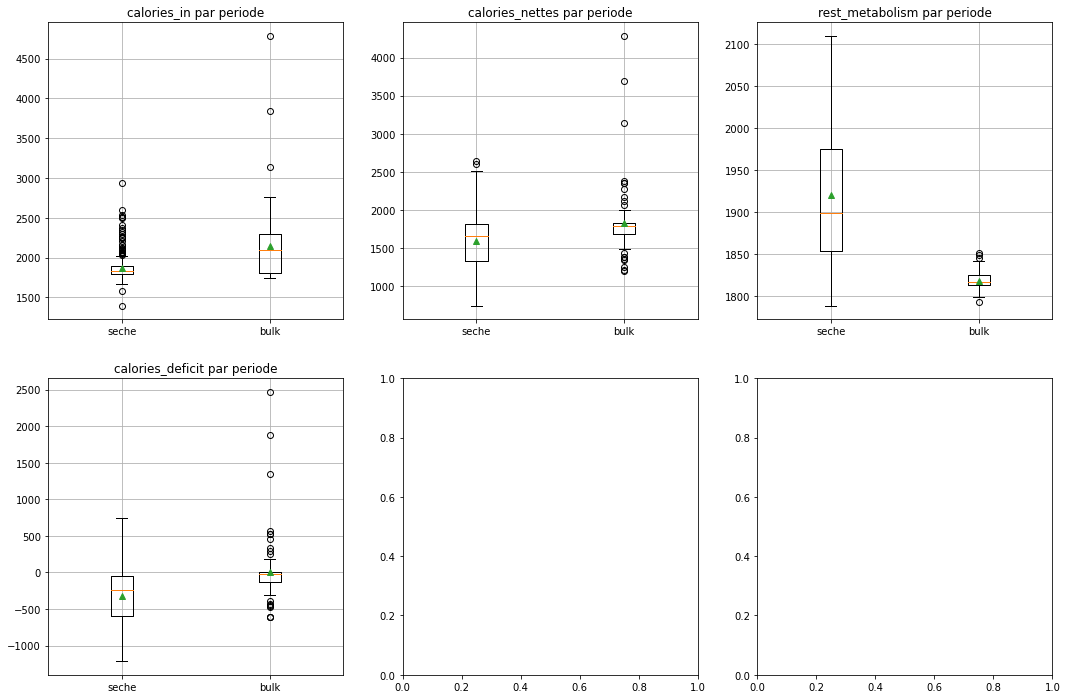

In [24]:
wl.plot_boxes(df_seche, df_bulk)

### En regardant les médianes seules des deux périodes (certes de longueur différente)
le déficit calorique se rapproche de 0 pour le bulk

### Première recherche sur Masse Totale

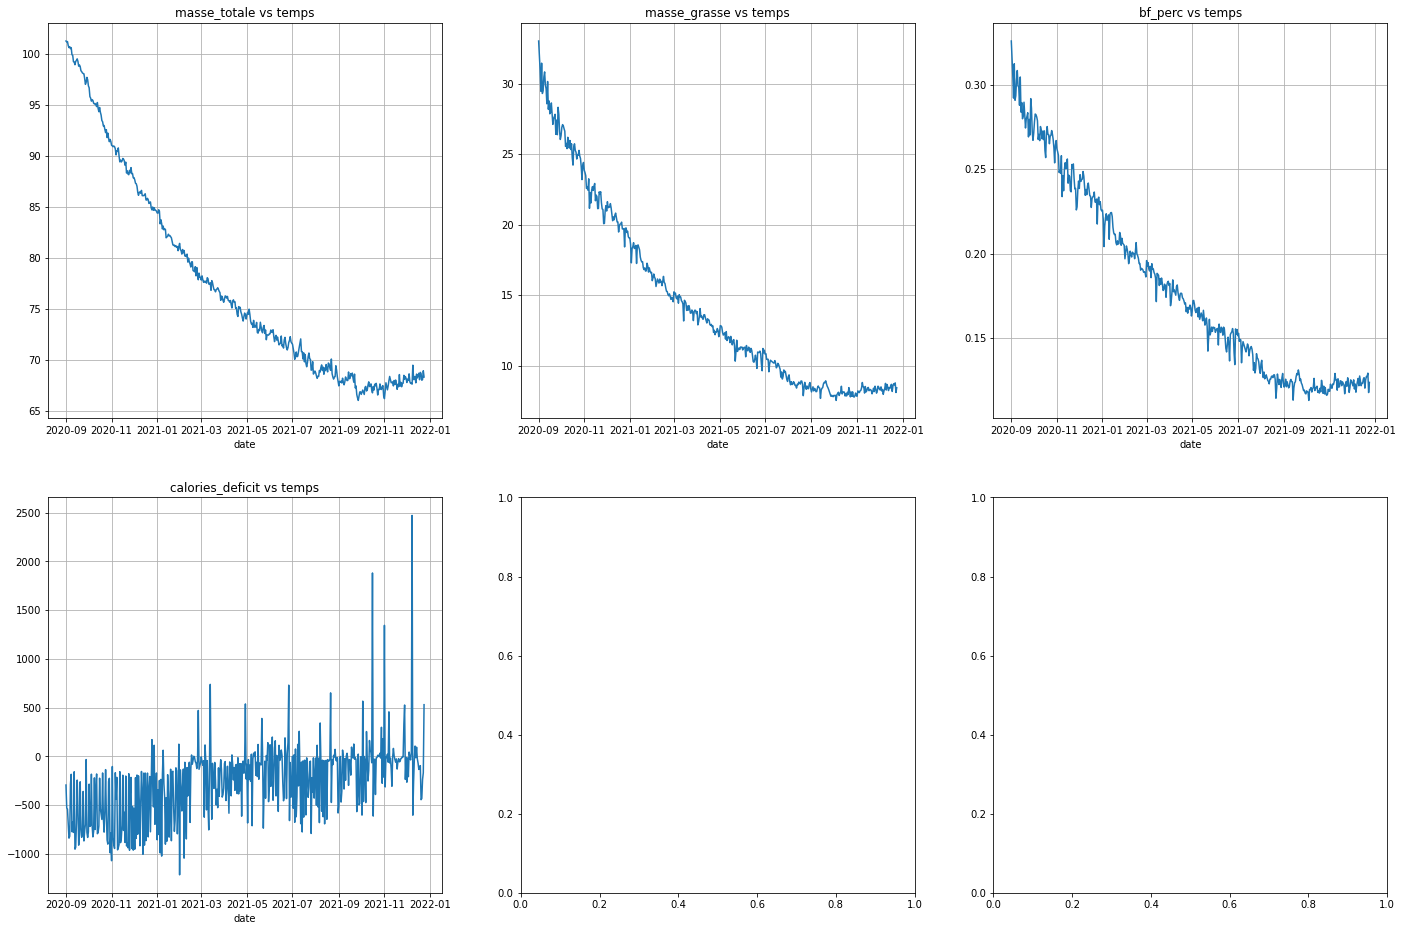

In [25]:
wl.plot_columns(df=df, columns_list=['masse_totale','masse_grasse','bf_perc','calories_deficit'])

# Quelques corrélations

In [26]:
def get_periode(df):
    
    debut = df.index[0]
    fin = df.index[-1]
    periode_str = debut.strftime('%d/%m/%Y') + ' - ' + fin.strftime('%d/%m/%Y')
    return periode_str
    

In [27]:
def correlations_moyenne(df,
                         window=15, 
                         columns_y = ['masse_totale', 'masse_grasse', 'masse_seche'], 
                         y_list = ['variation_masse_totale_moyenne', 'variation_masse_grasse_moyenne', 'variation_masse_seche_moyenne'],
                         columns_x = ['calories_deficit', 'calories_cardio', 'calories_exercice', 'calories_strength'],
                         x_list = ['calories_deficit_moyenne', 'calories_cardio_moyenne', 'calories_strength_moyenne']
                         ):
    
    columns_y_variation_moyenne = [ 'variation_' + c + '_moyenne' for c in columns_y]
    columns_x_moyenne = [ c + '_moyenne' for c in columns_x]
    columns_all = columns_x + columns_y
    
    df_test = df[columns_all]
    
    name = get_periode(df)
    
    for c1, c2 in zip(columns_y, columns_y_variation_moyenne):
        df_test.loc[:,c2] = df_test[c1].diff(1).rolling(window).mean().to_numpy()
        
    for c1, c2 in zip(columns_x, columns_x_moyenne):
        df_test.loc[:,c2] = df_test[c1].rolling(window).mean().shift(1).to_numpy()
        
    df_test = df_test[window:]
    
    df_test.drop(columns = columns_x + columns_y, inplace=True)
    
    display(df_test.corr())
    
    nx = len(x_list)
    ny = len(y_list)
    unit_size = 6
    
    fig,ax = plt.subplots(ny, nx, figsize=(nx*unit_size, ny*unit_size))
    
    fig.suptitle('Periode : ' + name + f'\nValeurs quotidiennes moyennes sur une fenêtre de {window} jours')

    for r,y in enumerate(y_list):
        for c,x in enumerate(x_list):
            ax[r,c] = df_test.plot.scatter(x,y, ax = ax[r,c], grid=True)

    plt.savefig('figure.jpg', format='jpg')
    plt.show()
    

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,variation_masse_totale_moyenne,variation_masse_grasse_moyenne,variation_masse_seche_moyenne,calories_deficit_moyenne,calories_cardio_moyenne,calories_exercice_moyenne,calories_strength_moyenne
variation_masse_totale_moyenne,1.000000,0.934188,0.826038,0.942823,-0.897743,-0.604240,0.899404
variation_masse_grasse_moyenne,0.934188,1.000000,0.570588,0.918821,-0.885197,-0.623653,0.853761
variation_masse_seche_moyenne,0.826038,0.570588,1.000000,0.718704,-0.668057,-0.405639,0.721540
calories_deficit_moyenne,0.942823,0.918821,0.718704,1.000000,-0.958057,-0.767416,0.814297
calories_cardio_moyenne,-0.897743,-0.885197,-0.668057,-0.958057,1.000000,0.854225,-0.786772
calories_exercice_moyenne,-0.604240,-0.623653,-0.405639,-0.767416,0.854225,1.000000,-0.351173
calories_strength_moyenne,0.899404,0.853761,0.721540,0.814297,-0.786772,-0.351173,1.000000


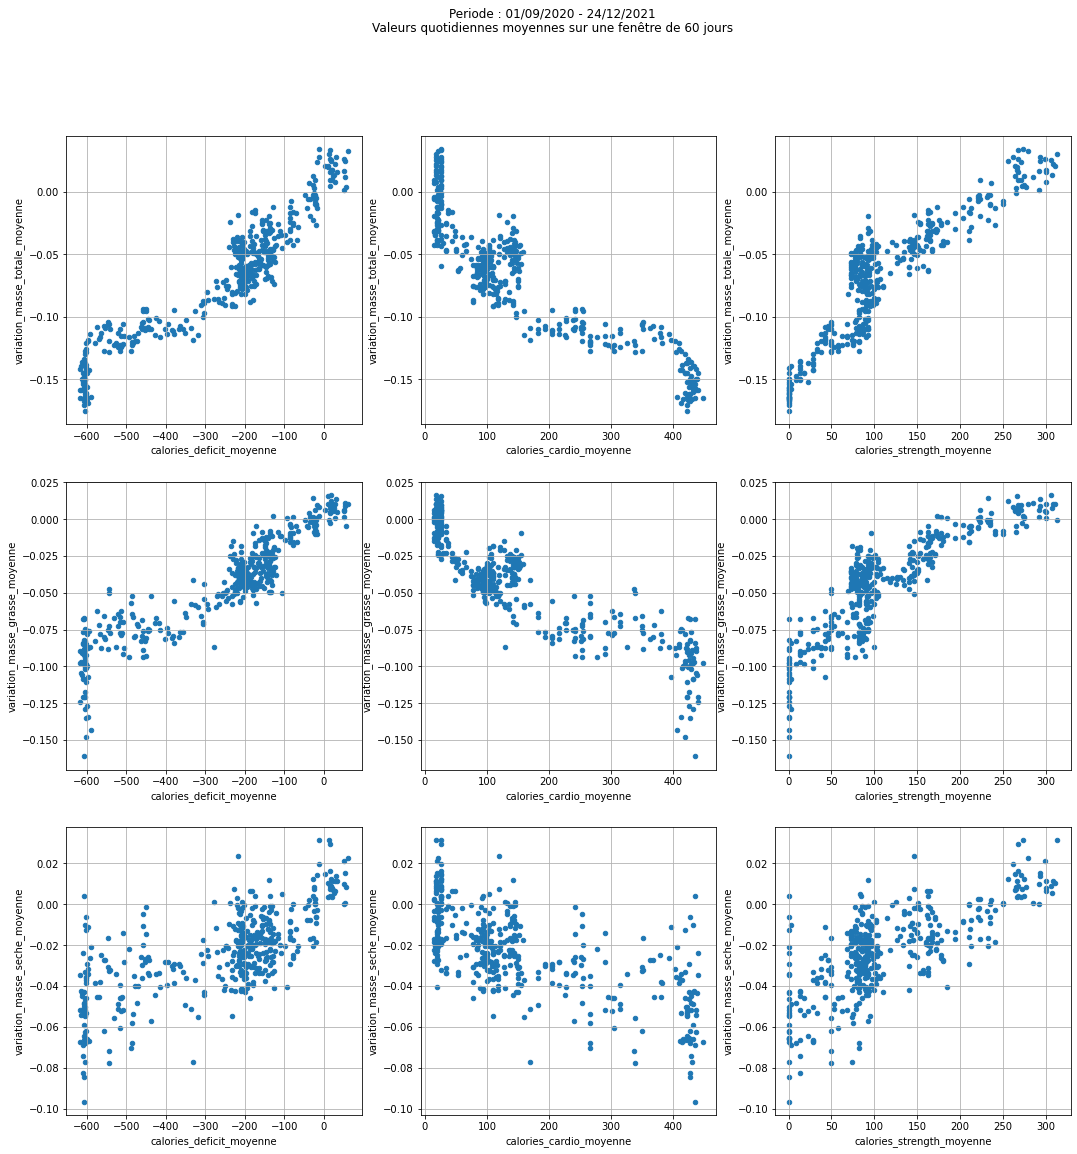

In [28]:
correlations_moyenne(df, window=60)

In [29]:
# correlations_moyenne(df_seche , window=60)

In [30]:
# correlations_moyenne(df_bulk, window=60)

# Nouvelle politique :
- déficit calorique quotidien : -100kcals à -200 kcals (rythme estimé : -750g graisse/mois) 
- (NB : deficit calorique = calories in - ( KMA + 10% + exercice ) )
- exercice musculation quotidien : >= 250 kcals ! 